# Choroid Plexus and Thalamic Nuclei

## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
from statsmodels.stats.multitest import multipletests
from IPython.display import clear_output

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

# import utils
from utils import zscore
from my_namespace import (
    presentation_cols,
    presentation_cols_both_ps, 
    colors
)

### Load Data

#### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/6-Thalamic_nuclei_and_disability"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data[MS_patients]
data_ms_z = zscore(data_ms)

grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}

### Functions

In [4]:
def run_R_script(p1, p2, p12, nobs):
    """
    Call R script to run Williams-Hotelling test and return p-value.

    Parameters:
    -----------
    p1 : float
        First correlation coefficient
    p2 : float
        Second correlation coefficient
    p12 : float
        Correlation between the two variables
    nobs : int
        Number of observations

    Returns:
    --------
    float
        The p-value from the Williams-Hotelling test
    """
    # Path to the R script (adjust this to where your R script is located)
    r_script_path = (
        "/home/srs-9/Projects/ms_mri/analysis/thalamus/run_williams_hotelling.R"
    )

    # Convert arguments to strings
    args = [str(p1), str(p2), str(p12), str(nobs)]

    # Call R script
    try:
        result = subprocess.run(
            ["Rscript", r_script_path] + args,
            capture_output=True,
            text=True,
            check=True,
        )

        # Parse the output (p-value)
        p_value = float(result.stdout.strip())
        return p_value

    except subprocess.CalledProcessError as e:
        print(f"Error running R script: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        raise
    except ValueError as e:
        print(f"Error parsing R output: {e}")
        print(f"R output was: {result.stdout}")
        raise


def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = regutils.residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["medial", "posterior", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif abs(pearson_results[struct][0]) > abs(pearson_results["THALAMUS_1"][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps

## Results section 6


### Baseline associations with disability

In [5]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]

predictors = [
    "WBV", 
    "GMV",
    "WMV",
    "WTV",
    "cortical_thickness",
    "CP",
    "T2LV_log1p",
    "PRL",
]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + age + Female + tiv + dzdur`

| predictor          |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|-------:|:------------------|-----:|
| WBV                | -0.3837 | 0.00031 | 0.1013 | [-0.582, -0.185]  | 0.27 |
| GMV                | -0.2601 | 0.0026  | 0.0826 | [-0.422, -0.0982] | 0.26 |
| WMV                | -0.2526 | 0.0069  | 0.0903 | [-0.43, -0.0756]  | 0.26 |
| WTV                | -0.2553 | 7.9e-07 | 0.0479 | [-0.349, -0.161]  | 0.29 |
| cortical_thickness | -0.195  | 2.5e-05 | 0.0432 | [-0.28, -0.11]    | 0.27 |
| CP                 |  0.0535 | 0.22    | 0.0438 | [-0.0322, 0.139]  | 0.25 |
| T2LV_log1p         |  0.1762 | 5.5e-05 | 0.0414 | [0.095, 0.257]    | 0.27 |
| PRL                |  0.1024 | 0.015   | 0.0413 | [0.0216, 0.183]   | 0.25 |

`SDMT ~ *predictor* + age + Female + tiv + dzdur`

| predictor          |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|-------:|:------------------|-----:|
| WBV                |  0.7144 | 3e-08   | 0.1262 | [0.467, 0.962]    | 0.24 |
| GMV                |  0.4034 | 0.0053  | 0.1426 | [0.124, 0.683]    | 0.2  |
| WMV                |  0.5467 | 7.6e-08 | 0.1001 | [0.35, 0.743]     | 0.22 |
| WTV                |  0.373  | 4.6e-10 | 0.0584 | [0.258, 0.487]    | 0.25 |
| cortical_thickness |  0.3614 | 1.5e-12 | 0.0491 | [0.265, 0.458]    | 0.25 |
| CP                 | -0.1556 | 0.0056  | 0.0562 | [-0.266, -0.0454] | 0.17 |
| T2LV_log1p         | -0.3245 | 4.6e-10 | 0.0506 | [-0.424, -0.225]  | 0.24 |
| PRL                | -0.1452 | 0.0053  | 0.0509 | [-0.245, -0.0454] | 0.17 |

### Regional Thalamic Atrophy

**No thalamic nucleus predicts disability after controlling for global thalamic atrophy**

In [6]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]
predictors = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
]
covariates = ["THALAMUS_1", "age", "Female", "tiv", "dzdur"]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols, inds=display_order).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + THALAMUS_1 + age + Female + tiv + dzdur`

| predictor   |    coef |   p_fdr |     se | ci               |   R2 |
|:------------|--------:|--------:|-------:|:-----------------|-----:|
| medial      |  0.1347 |    0.51 | 0.1182 | [-0.0969, 0.366] | 0.29 |
| anterior    | -0.1053 |    0.46 | 0.0667 | [-0.236, 0.0255] | 0.29 |
| posterior   | -0.0968 |    0.56 | 0.1337 | [-0.359, 0.165]  | 0.29 |
| ventral     | -0.0626 |    0.56 | 0.1081 | [-0.275, 0.149]  | 0.29 |

`SDMT ~ *predictor* + THALAMUS_1 + age + Female + tiv + dzdur`

| predictor   |   coef |   p_fdr |     se | ci              |   R2 |
|:------------|-------:|--------:|-------:|:----------------|-----:|
| posterior   | 0.0798 |    0.81 | 0.1269 | [-0.169, 0.329] | 0.25 |
| anterior    | 0.0667 |    0.81 | 0.0596 | [-0.05, 0.183]  | 0.25 |
| ventral     | 0.0494 |    0.81 | 0.1072 | [-0.161, 0.26]  | 0.25 |
| medial      | 0.0333 |    0.81 | 0.1359 | [-0.233, 0.3]   | 0.25 |

In [7]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]
predictors = [
    "WTV",
    "medial",
    "posterior",
    "ventral",
    "anterior"
]
covariates = ["WBV", "age", "Female", "tiv", "dzdur"]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols, inds=display_order).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + WBV + age + Female + tiv + dzdur`

| predictor   |    coef |   p_fdr |     se | ci                |   R2 |
|:------------|--------:|--------:|-------:|:------------------|-----:|
| WTV         | -0.2433 |  0.0011 | 0.0671 | [-0.375, -0.112]  | 0.28 |
| posterior   | -0.2051 |  0.0011 | 0.0584 | [-0.32, -0.0906]  | 0.28 |
| ventral     | -0.2004 |  0.0023 | 0.0642 | [-0.326, -0.0745] | 0.28 |
| anterior    | -0.1676 |  0.0023 | 0.0536 | [-0.273, -0.0625] | 0.28 |
| medial      | -0.1447 |  0.019  | 0.0616 | [-0.265, -0.024]  | 0.27 |

`SDMT ~ *predictor* + WBV + age + Female + tiv + dzdur`

| predictor   |   coef |   p_fdr |     se | ci              |   R2 |
|:------------|-------:|--------:|-------:|:----------------|-----:|
| WTV         | 0.2455 |  0.0049 | 0.0793 | [0.09, 0.401]   | 0.25 |
| posterior   | 0.2083 |  0.0049 | 0.0673 | [0.0764, 0.34]  | 0.25 |
| ventral     | 0.2049 |  0.0053 | 0.0731 | [0.0617, 0.348] | 0.25 |
| medial      | 0.1911 |  0.0053 | 0.0675 | [0.0588, 0.323] | 0.25 |
| anterior    | 0.1445 |  0.0053 | 0.0519 | [0.0428, 0.246] | 0.25 |

### Moderated Mediation Models


The effect of CP on thalamus is fully mediated by LV expansion

In [6]:
model_data = zscore(data[MS_patients])

formula = "WTV ~ CP*T2LV_log1p + age + Female + tiv"
res = smf.ols(formula, data=model_data).fit(cov_type="HC3")
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    WTV   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     130.0
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           8.12e-96
Time:                        20:46:04   Log-Likelihood:                -412.46
No. Observations:                 468   AIC:                             838.9
Df Residuals:                     461   BIC:                             868.0
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1223      0.068     -1.808

In [18]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="EDSS_sqrt",
    m=["WTV"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2965   0.2855 0.7145 31.3358    6  446   0.0000

Coefficients

         coeff     se       t      p    LLCI    ULCI
Cons    0.1226 0.1002  1.2241 0.2216 -0.0737  0.3189
CP     -0.0600 0.0498 -1.2042 0.2292 -0.1575  0.0376
age     0.2877 0.0523  5.5052 0.0000  0.1853  0.3901
Female -0.1727 0.1176 -1.4681 0.1428 -0.4032  0.0579
tiv     0.0392 0.0540  0.7248 0.4689 -0.0667  0.1450
dzdur   0.1478 0.0513  2.8822 0.0041  0.0473  0.2484
WTV    -0.2839 0.0545 -5.2116 0.0000 -0.3907 -0.1772

-------------------------------------------------------------------------

Outcome = WTV 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.4731   0.4660 0.5385 80.2778    5  447   0.0000

Coefficients

         coeff     se        t      p    LLCI    ULCI
Cons   -0.2033 0.0864  -2.3531 0.0191 -0.3727 -0.034

In [26]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="EDSS_sqrt",
    m=["WTV"],
    w="T2LV_log1p",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2965   0.2855 0.7145 31.3358    6  446   0.0000

Coefficients

         coeff     se       t      p    LLCI    ULCI
Cons    0.1226 0.1002  1.2241 0.2216 -0.0737  0.3189
CP     -0.0600 0.0498 -1.2042 0.2292 -0.1575  0.0376
age     0.2877 0.0523  5.5052 0.0000  0.1853  0.3901
Female -0.1727 0.1176 -1.4681 0.1428 -0.4032  0.0579
tiv     0.0392 0.0540  0.7248 0.4689 -0.0667  0.1450
dzdur   0.1478 0.0513  2.8822 0.0041  0.0473  0.2484
WTV    -0.2839 0.0545 -5.2116 0.0000 -0.3907 -0.1772

-------------------------------------------------------------------------

Outcome = WTV 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6646   0.6586 0.3443 125.9957    7  445   0.0000

Coefficients

                coeff     se        t      p    LLCI    ULCI
Cons          -0.1538 0.0707  -2.1751 0.030

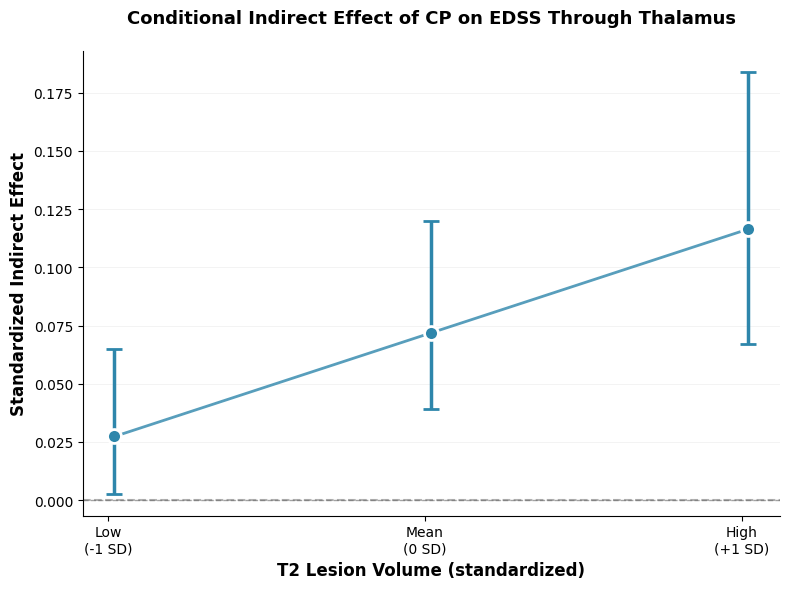

In [27]:
# Data
indirect_model = p2.indirect_model.coeff_summary()
t2lv_values = indirect_model['T2LV_log1p']
indirect_effects = indirect_model['Effect']
ci_lower = indirect_model['BootLLCI']
ci_upper = indirect_model['BootULCI']

# Calculate errors
errors_lower = indirect_effects - ci_lower
errors_upper = ci_upper - indirect_effects
errors = np.array([errors_lower, errors_upper])

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line and points
ax.plot(t2lv_values, indirect_effects, '-o', 
        color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)

# Add error bars
ax.errorbar(t2lv_values, indirect_effects, yerr=errors,
            fmt='o', markersize=10, 
            color='#2E86AB', ecolor='#2E86AB', 
            capsize=6, capthick=2.5, linewidth=2.5,
            markeredgewidth=2, markeredgecolor='white')


# ax.errorbar(t2lv_levels, indirect_effects, 
#             yerr=errors, fmt='o', markersize=10, 
#             color='#2E86AB', ecolor='#2E86AB', 
#             capsize=6, capthick=2.5, linewidth=2.5,
#             markeredgewidth=2, markeredgecolor='white')

# Add horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Customize plot
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['Low\n(-1 SD)', 'Mean\n(0 SD)', 'High\n(+1 SD)'])
ax.set_xlabel('T2 Lesion Volume (standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Standardized Indirect Effect', fontsize=12, fontweight='bold')
ax.set_title('Conditional Indirect Effect of CP on EDSS Through Thalamus',
             fontsize=13, fontweight='bold', pad=20)
# ax.set_ylim(0, 0.25)
# ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)



ax.axhline(y=0, color='#666666', linestyle='--', linewidth=1.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, axis='y')

plt.tight_layout()
plt.show()

In [17]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="SDMT",
    m=["WTV"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2551   0.2434 0.7566 25.5125    6  447   0.0000

Coefficients

         coeff     se       t      p    LLCI    ULCI
Cons   -0.1345 0.1034 -1.3010 0.1939 -0.3371  0.0681
CP     -0.0054 0.0519 -0.1042 0.9170 -0.1070  0.0962
age    -0.2602 0.0538 -4.8358 0.0000 -0.3656 -0.1547
Female  0.1832 0.1216  1.5068 0.1326 -0.0551  0.4216
tiv    -0.0047 0.0558 -0.0842 0.9329 -0.1141  0.1047
dzdur   0.0516 0.0530  0.9745 0.3303 -0.0522  0.1555
WTV     0.3704 0.0561  6.5980 0.0000  0.2604  0.4804

-------------------------------------------------------------------------

Outcome = WTV 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.4656   0.4585 0.5359 78.0758    5  448   0.0000

Coefficients

         coeff     se        t      p    LLCI    ULCI
Cons   -0.1856 0.0866  -2.1442 0.0326 -0.3553 -0.0159
CP 

In [22]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="SDMT",
    m=["WTV"],
    w="T2LV_log1p",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2551   0.2434 0.7566 25.5125    6  447   0.0000

Coefficients

         coeff     se       t      p    LLCI    ULCI
Cons   -0.1345 0.1034 -1.3010 0.1939 -0.3371  0.0681
CP     -0.0054 0.0519 -0.1042 0.9170 -0.1070  0.0962
age    -0.2602 0.0538 -4.8358 0.0000 -0.3656 -0.1547
Female  0.1832 0.1216  1.5068 0.1326 -0.0551  0.4216
tiv    -0.0047 0.0558 -0.0842 0.9329 -0.1141  0.1047
dzdur   0.0516 0.0530  0.9745 0.3303 -0.0522  0.1555
WTV     0.3704 0.0561  6.5980 0.0000  0.2604  0.4804

-------------------------------------------------------------------------

Outcome = WTV 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6584   0.6523 0.3441 122.8228    7  446   0.0000

Coefficients

                coeff     se        t      p    LLCI    ULCI
Cons          -0.1300 0.0708  -1.8366 0.0669 -0.

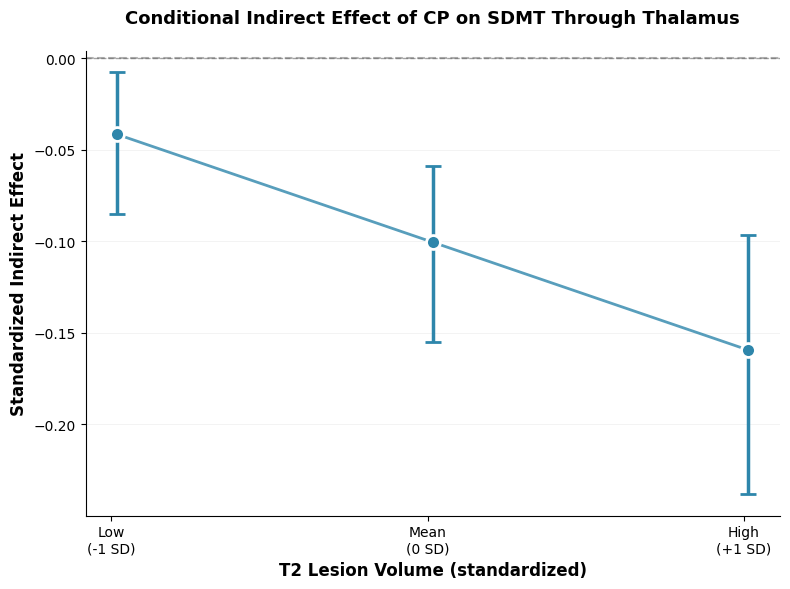

In [24]:
# Data
indirect_model = p2.indirect_model.coeff_summary()
t2lv_values = indirect_model['T2LV_log1p']
indirect_effects = indirect_model['Effect']
ci_lower = indirect_model['BootLLCI']
ci_upper = indirect_model['BootULCI']

# Calculate errors
errors_lower = indirect_effects - ci_lower
errors_upper = ci_upper - indirect_effects
errors = np.array([errors_lower, errors_upper])

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line and points
ax.plot(t2lv_values, indirect_effects, '-o', 
        color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)

# Add error bars
ax.errorbar(t2lv_values, indirect_effects, yerr=errors,
            fmt='o', markersize=10, 
            color='#2E86AB', ecolor='#2E86AB', 
            capsize=6, capthick=2.5, linewidth=2.5,
            markeredgewidth=2, markeredgecolor='white')


# ax.errorbar(t2lv_levels, indirect_effects, 
#             yerr=errors, fmt='o', markersize=10, 
#             color='#2E86AB', ecolor='#2E86AB', 
#             capsize=6, capthick=2.5, linewidth=2.5,
#             markeredgewidth=2, markeredgecolor='white')

# Add horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Customize plot
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['Low\n(-1 SD)', 'Mean\n(0 SD)', 'High\n(+1 SD)'])
ax.set_xlabel('T2 Lesion Volume (standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Standardized Indirect Effect', fontsize=12, fontweight='bold')
ax.set_title('Conditional Indirect Effect of CP on SDMT Through Thalamus',
             fontsize=13, fontweight='bold', pad=20)
# ax.set_ylim(0, 0.25)
# ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)



ax.axhline(y=0, color='#666666', linestyle='--', linewidth=1.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, axis='y')

plt.tight_layout()
plt.show()

In [67]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="EDSS_sqrt",
    m=["THALAMUS_1", "cortical_thickness"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2995   0.2869 0.7131 27.1804    7  445   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons               -0.0128 0.0397 -0.3236 0.7464 -0.0906  0.0650
CP                 -0.0652 0.0499 -1.3058 0.1923 -0.1629  0.0326
age                 0.2685 0.0541  4.9612 0.0000  0.1624  0.3745
Female             -0.0693 0.0484 -1.4337 0.1524 -0.1641  0.0254
tiv                 0.0288 0.0545  0.5279 0.5978 -0.0781  0.1356
dzdur               0.1503 0.0513  2.9313 0.0035  0.0498  0.2508
THALAMUS_1         -0.2331 0.0661 -3.5289 0.0005 -0.3626 -0.1036
cortical_thickness -0.0803 0.0589 -1.3628 0.1736 -0.1957  0.0352

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.4

In [59]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="SDMT",
    m=["cortical_thickness", "THALAMUS_1"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2807   0.2678 0.7322 24.8632    7  446   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons                0.0078 0.0402  0.1945 0.8459 -0.0709  0.0866
CP                  0.0109 0.0512  0.2124 0.8319 -0.0895  0.1112
age                -0.2039 0.0548 -3.7205 0.0002 -0.3113 -0.0965
Female              0.0667 0.0493  1.3534 0.1766 -0.0299  0.1632
tiv                 0.0194 0.0553  0.3503 0.7263 -0.0889  0.1277
dzdur               0.0445 0.0522  0.8526 0.3943 -0.0578  0.1467
cortical_thickness  0.2362 0.0593  3.9796 0.0001  0.1199  0.3525
THALAMUS_1          0.2223 0.0667  3.3352 0.0009  0.0917  0.3529

-------------------------------------------------------------------------

Outcome = cortical_thickness 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 

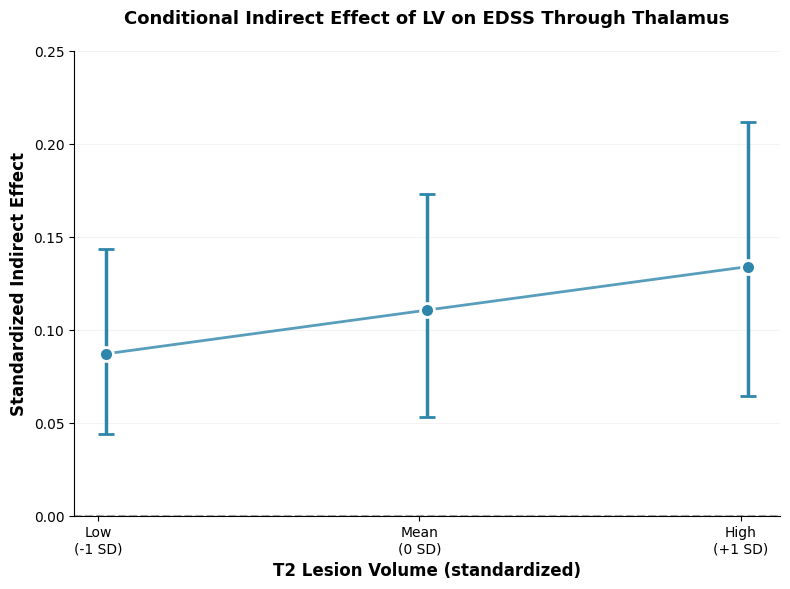

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Data
t2lv_values = np.array([-0.9745, 0.0234, 1.0213])
indirect_effects = np.array([0.0870, 0.1105, 0.1339])
ci_lower = np.array([0.0439, 0.0532, 0.0641])
ci_upper = np.array([0.1432, 0.1729, 0.2115])

# Calculate errors
errors_lower = indirect_effects - ci_lower
errors_upper = ci_upper - indirect_effects
errors = np.array([errors_lower, errors_upper])

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line and points
ax.plot(t2lv_values, indirect_effects, '-o', 
        color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)

# Add error bars
ax.errorbar(t2lv_values, indirect_effects, yerr=errors,
            fmt='o', markersize=10, 
            color='#2E86AB', ecolor='#2E86AB', 
            capsize=6, capthick=2.5, linewidth=2.5,
            markeredgewidth=2, markeredgecolor='white')


# ax.errorbar(t2lv_levels, indirect_effects, 
#             yerr=errors, fmt='o', markersize=10, 
#             color='#2E86AB', ecolor='#2E86AB', 
#             capsize=6, capthick=2.5, linewidth=2.5,
#             markeredgewidth=2, markeredgecolor='white')

# Add horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Customize plot
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['Low\n(-1 SD)', 'Mean\n(0 SD)', 'High\n(+1 SD)'])
ax.set_xlabel('T2 Lesion Volume (standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Standardized Indirect Effect', fontsize=12, fontweight='bold')
ax.set_title('Conditional Indirect Effect of LV on EDSS Through Thalamus',
             fontsize=13, fontweight='bold', pad=20)
ax.set_ylim(0, 0.25)
# ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)



ax.axhline(y=0, color='#666666', linestyle='--', linewidth=1.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, axis='y')

plt.tight_layout()
plt.show()

In [110]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="LV_log",
    y="SDMT",
    m=["THALAMUS_1"],
    w="t2lv_log",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2621   0.2505 0.7510 26.4093    6  446   0.0000

Coefficients

             coeff     se       t      p    LLCI    ULCI
Cons        0.0078 0.0407  0.1918 0.8480 -0.0720  0.0876
LV_log     -0.1109 0.0606 -1.8307 0.0678 -0.2296  0.0078
age        -0.2355 0.0546 -4.3174 0.0000 -0.3424 -0.1286
Female      0.0812 0.0494  1.6428 0.1011 -0.0157  0.1781
tiv         0.0464 0.0615  0.7551 0.4506 -0.0740  0.1669
dzdur       0.0473 0.0529  0.8946 0.3715 -0.0563  0.1509
THALAMUS_1  0.3036 0.0633  4.7975 0.0000  0.1796  0.4276

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6402   0.6337 0.3631 113.1241    7  445   0.0000

Coefficients

                  coeff     se        t      p    LLCI    ULCI
Cons   

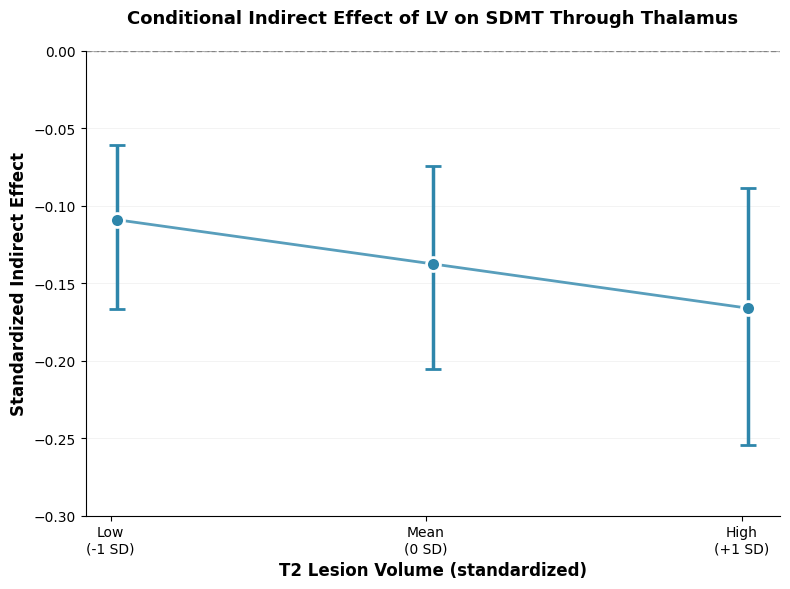

In [6]:
# Data
t2lv_values = np.array([-0.9788, 0.0215, 1.0218])
indirect_effects = np.array([-0.1091, -0.1376, -0.1662])
ci_lower = np.array([-0.1667, -0.2056, -0.2543])
ci_upper = np.array([-0.0610, -0.0745, -0.0885])

# Calculate errors
errors_lower = indirect_effects - ci_lower
errors_upper = ci_upper - indirect_effects
errors = np.array([errors_lower, errors_upper])

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line and points
ax.plot(t2lv_values, indirect_effects, '-o', 
        color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)

# Add error bars
ax.errorbar(t2lv_values, indirect_effects, yerr=errors,
            fmt='o', markersize=10, 
            color='#2E86AB', ecolor='#2E86AB', 
            capsize=6, capthick=2.5, linewidth=2.5,
            markeredgewidth=2, markeredgecolor='white')


# ax.errorbar(t2lv_levels, indirect_effects, 
#             yerr=errors, fmt='o', markersize=10, 
#             color='#2E86AB', ecolor='#2E86AB', 
#             capsize=6, capthick=2.5, linewidth=2.5,
#             markeredgewidth=2, markeredgecolor='white')

# Add horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Customize plot
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['Low\n(-1 SD)', 'Mean\n(0 SD)', 'High\n(+1 SD)'])
ax.set_xlabel('T2 Lesion Volume (standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Standardized Indirect Effect', fontsize=12, fontweight='bold')
ax.set_title('Conditional Indirect Effect of LV on SDMT Through Thalamus',
             fontsize=13, fontweight='bold', pad=20)
ax.set_ylim(-0.3, 0)
# ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)



ax.axhline(y=0, color='#666666', linestyle='--', linewidth=1.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, axis='y')

plt.tight_layout()
plt.show()

In [52]:
model_data.to_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/R_data/model_data.csv")

In [73]:
formula = "SDMT ~ t2lv_log*LV_log + age + Female + tiv"
model = sm.OLS.from_formula(formula, data=data_ms_z).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   SDMT   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     28.93
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           2.97e-29
Time:                        19:22:12   Log-Likelihood:                -568.81
No. Observations:                 453   AIC:                             1152.
Df Residuals:                     446   BIC:                             1180.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0609      0.044     

---

### Assumption Checks

Linearity

Check: Residual plots, component-residual plots
Test: Look for curved patterns in residuals vs. fitted values

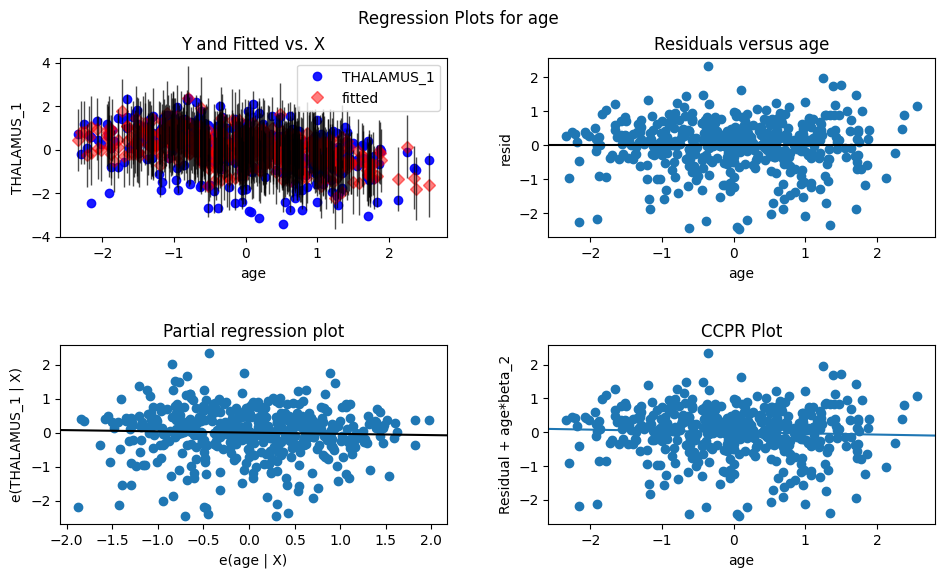

Breusch-Pagan p-value: 5.506487166550046e-07


In [129]:
from statsmodels.stats.diagnostic import het_breuschpagan

model_data = data_ms_z

model1 = sm.OLS.from_formula("THALAMUS_1 ~ CP + age + Female + tiv + dzdur", data=model_data).fit()
# model1 = sm.OLS.from_formula("EDSS_sqrt ~ THALAMUS_1 + age + Female + tiv + dzdur", data=model_data).fit()

fig = sm.graphics.plot_regress_exog(model1, 'age')
fig.set_figheight(6)
fig.set_figwidth(10)
plt.show()

bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

In [133]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# For the Thalamus model with interaction
model_data['LV_log:t2lv_log'] = model_data['LV_log']*model_data['t2lv_log']
X = model_data[['LV_log', 't2lv_log', 'LV_log:t2lv_log', 'age', 'Female', 'tiv', 'dzdur']]
X = X.dropna()
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          Variable       VIF
0           LV_log  1.638503
1         t2lv_log  1.412942
2  LV_log:t2lv_log  1.016891
3              age  1.763286
4           Female  1.438500
5              tiv  1.441871
6            dzdur  1.640535


---

### LV expansion and thalamic volumes

Does thalamic volume loss have regional relationships with expansion of the central CSF compartment?

**Steps**

1. Residualize out the effect of age, sex, TIV, and peripheral CSF volume from LV and each of the thalamic nuclei
2. Compute the Pearson correlations (r) between the residualized CP and each of the nuclei as well as the whole thalamus
3. Use the [Williams-Hotelling test](https://rdrr.io/github/bcdudek/bcdstats/man/test2r.t2.html) to compare the sizes of the r's (this procedure was used in Bergsland et al. 2020 as well)

In [24]:
disease_group = "MS"
influenced_var = "EDSS_sqrt"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["periCSF", "age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [25]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(
    Markdown(
        f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"
    )
)
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and EDSS_sqrt:**

```visualprolog
THALAMUS_1: r=-0.286, p=5.69e-10
medial: r=-0.242, p=1.80e-07
posterior: r=-0.278, p=1.78e-09
anterior: r=-0.244, p=1.52e-07
ventral: r=-0.264, p=1.26e-08
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
- medial < THALAMUS_1: p=1.49e-02
  posterior = THALAMUS_1: p=6.20e-01
  anterior = THALAMUS_1: p=2.61e-01
  ventral = THALAMUS_1: p=3.17e-01
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=1.41e-01
  medial = anterior: p=9.73e-01
  medial = ventral: p=5.23e-01
  posterior = anterior: p=3.87e-01
  posterior = ventral: p=6.75e-01
  anterior = ventral: p=6.29e-01
```


---

## Extras

In [ ]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]

predictors = [
    "WTV",
    "medial",
    "posterior",
    "ventral",
    "anterior",
    "cortical_thickness",
    "brain",
    "white",
    "grey",
    "CP",
    "t2lv_log",
    "T2LV_log1p",
    "periV_T2LV_log1p",
    "juxcort_T2LV_log1p",
    "subcort_T2LV_log1p",
    "infraT_T2LV_log1p",
    "PRL",
    "LV_log",
    "thirdV_log",
    "fourthV_log",
    "allCSF",
    "periCSF",
    # need to decide: CCR vs CCR2
    "CCR_log", 
    "CCR2_log",
    "periCSF_frac_reflect_log"
]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols).to_markdown()
        )
    )